In [26]:
from pathlib import Path
import pickle
import numpy as np

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
import seaborn as sns

In [29]:
SETTINGS = ['hkust-transformer-adam-lr28','hkust-transformer-adamw-lr28','hkust-transformer-sgd-lr28',
            'hkust-0shot','hkust-transformer-sgd-freeze-ext', 'hkust-transformer-sgd-freeze-encoder',
            'hkust-transformer-sgd-freeze-decoder'
           ]
PRETRAIN_SUFFIXES = ['cross-test-hkust','cross-test-hkust-metabsz5','cross-test-hkust-metabsz1']
ALGOS = ['fomaml','multi']
#ACCENTS = ['canada','scotland','southatlandtic'] # meta-val
#ACCENTS = ['african','hongkong','singapore','indian','philippines'] #meta-test(cross)
ACCENTS = ['canada','scotland','southatlandtic','african','hongkong','singapore','indian','philippines'] # meta-val + meta-test(cross)

In [30]:
root_path = Path.cwd().joinpath('testing-logs','evaluation')

In [31]:
class Entry:
    def __init__(self, setting, pretrain_suffix, algo, accent,runs=0):
        self.setting = setting
        self.pretrain_suffix = pretrain_suffix
        self.algo = algo
        self.accent = accent
        self.runs = runs
        
        self.collect_info()
        
        
    def satisfy(self, attr, tgt):
        return getattr(self, attr) == tgt
    
    def collect_info(self):
        # dev_cer, dev_wer, eval_cer, eval_wer
        self.info = dict()
        for stat in ['dev_cer','dev_wer','eval_cer','eval_wer', 'best_step']:
            self.info[stat] = {'x':list(), 'y':list()}
            
        check_path = root_path.joinpath(self.setting, self.algo, self.pretrain_suffix)
        for step_path in check_path.iterdir():
            final_path = step_path.joinpath(self.accent, str(self.runs))
            step = int(step_path.name[4:])
            
            if not final_path.joinpath('greedy_decode','cer').exists():
                continue
                
                
            with open(final_path.joinpath('best_cer'),'r') as f:
                dev_cer = float(f.read().strip().split(' ')[1])
                self.info['dev_cer']['x'].append(step//1000)
                self.info['dev_cer']['y'].append(dev_cer)
                
            with open(final_path.joinpath('best_wer'),'r') as f:
                foo = f.read().strip().split(' ')
                
                best_step = int(foo[0])
                #print(best_step)
                dev_wer = float(foo[1])
                
                self.info['best_step']['x'].append(step//1000)
                self.info['best_step']['y'].append(best_step)
                self.info['dev_wer']['x'].append(step//1000)
                self.info['dev_wer']['y'].append(dev_wer)
                
            with open(final_path.joinpath('greedy_decode','cer')) as f:
                eval_cer = float(f.read().strip())
                self.info['eval_cer']['x'].append(step//1000)
                self.info['eval_cer']['y'].append(eval_cer)
                
            with open(final_path.joinpath('greedy_decode','wer')) as f:
                eval_wer = float(f.read().strip())
                self.info['eval_wer']['x'].append(step//1000)
                self.info['eval_wer']['y'].append(eval_wer)

In [32]:
#entry = Entry(setting, pretrain_suffix, algo, accent)
#entry = Entry('hkust-transformer-sgd-lr28', 'cross-test-hkust-metabsz5', 'fomaml', 'southatlandtic')

entries = []
for setting in SETTINGS:
    for pretrain_suffix in PRETRAIN_SUFFIXES:
        for algo in ALGOS:
            for accent in ACCENTS:
                p = root_path.joinpath(setting, algo, pretrain_suffix)
                if p.exists():
                    #print(pretrain_suffix)
                    entries.append(Entry(setting,pretrain_suffix,algo, accent))
                    #print("=========================================================")

In [40]:
def plot_learning_curve(stat, criterias, accents=list(), legend='pretrain_suffix'):

    plt.figure(figsize=(22, 4))
    NUM_FIGS = len(accents)

    for accent_n, accent in enumerate(accents,1):
        
        ###########
        criterias['accent'] = accent
        #criterias = {'setting': setting, 'accent': accent}
        ###########
        
        target_entries = list()

        for entry in entries:
            ok = True
            for attr, tgt in criterias.items():
                if isinstance(tgt, list):
                    check = any([entry.satisfy(attr,t) for t in tgt])
                else:
                    check = entry.satisfy(attr, tgt)

                if not check:
                    ok = False
                    break
            if ok:
                target_entries.append(entry)

        plt.subplot(1, NUM_FIGS, accent_n)
        
        plot_infos = {getattr(entry, legend): entry.info[stat] for entry in target_entries}
        for pretrain_suffix, plot_info in plot_infos.items():
            sns.lineplot(x = plot_info['x'], y = plot_info['y'],label=pretrain_suffix,markers=True)
        plt.title("Adaptation on " +  r"$\bf{" + accent + "}$ " + stat)
        plt.xlabel("Pretraining step (x1000)")
        plt.ylabel(stat)
    
            

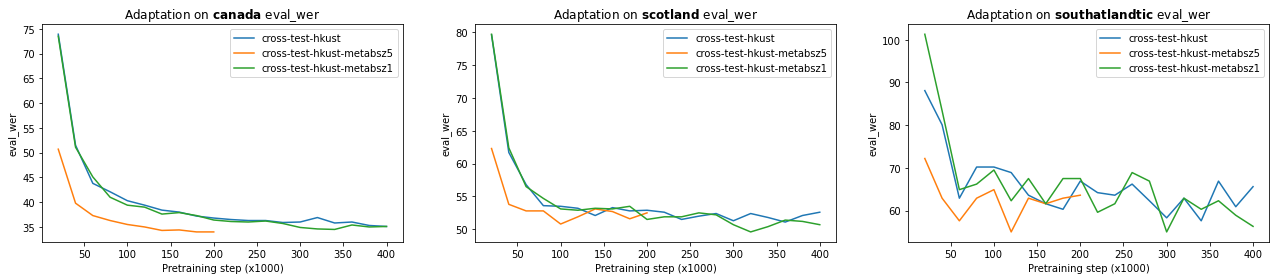

In [41]:
plot_learning_curve('eval_wer', {'setting':'hkust-transformer-sgd-lr28'},['canada','scotland','southatlandtic'],'pretrain_suffix')

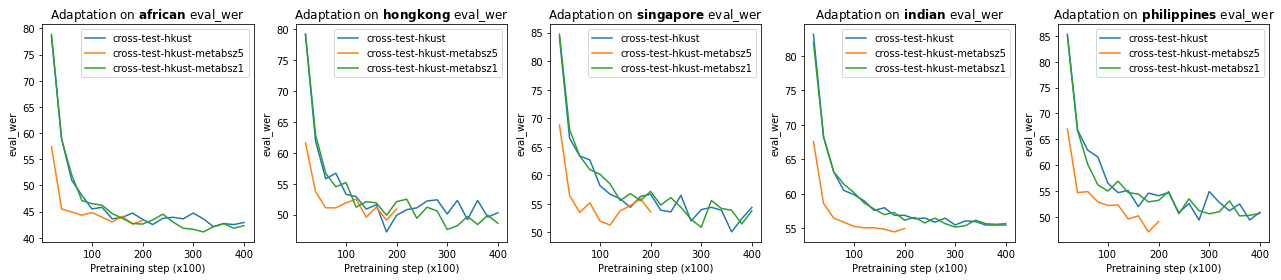

In [17]:
plot_learning_curve('eval_wer', {'setting':'hkust-transformer-sgd-lr28'},['african','hongkong','singapore','indian','philippines'],'pretrain_suffix')

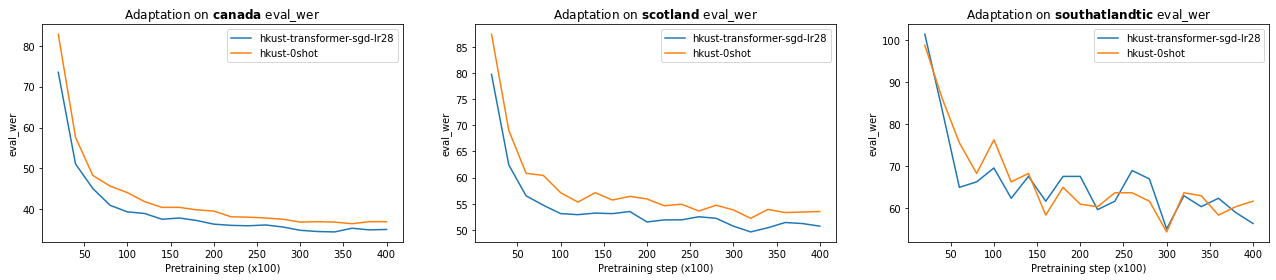

In [23]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz1'},['canada','scotland','southatlandtic'],'setting')

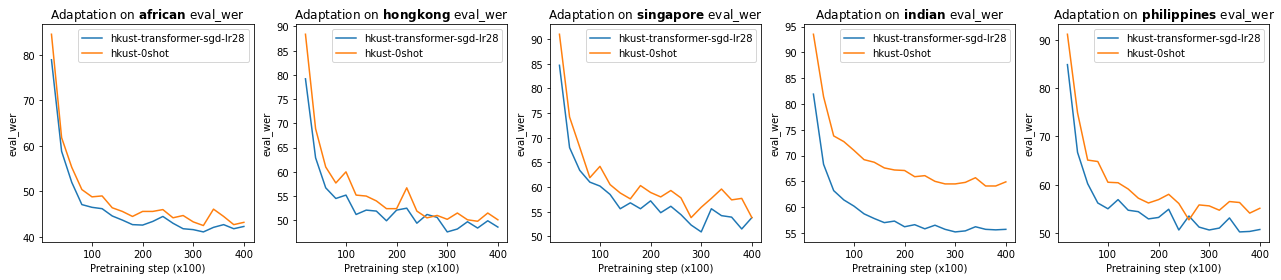

In [35]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz1'},['african','hongkong','singapore','indian','philippines'],'setting')

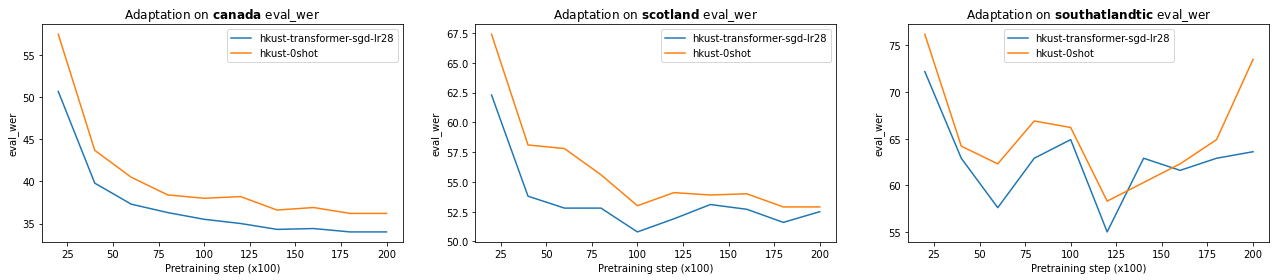

In [24]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz5'},['canada','scotland','southatlandtic'],'setting')

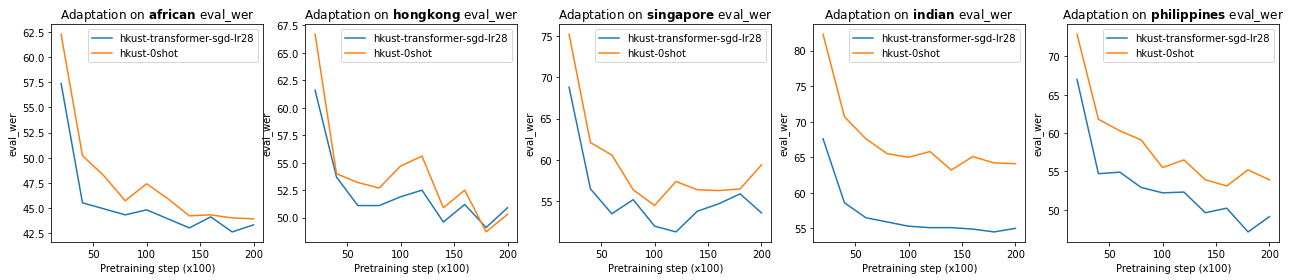

In [36]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust-metabsz5'},['african','hongkong','singapore','indian','philippines'],'setting')

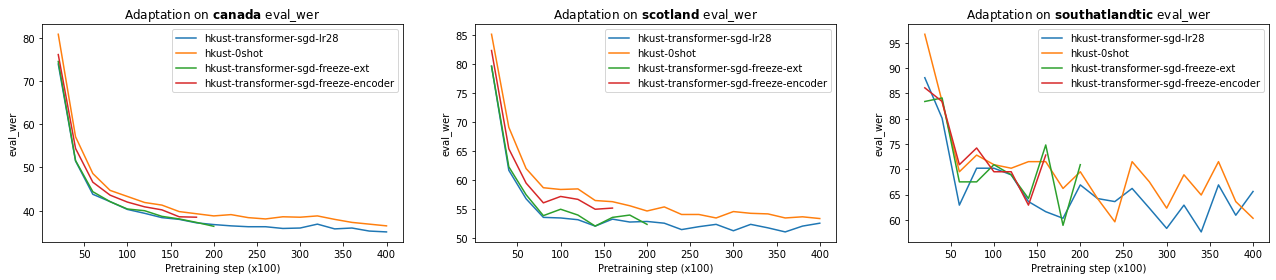

In [34]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust'},['canada','scotland','southatlandtic'],'setting')

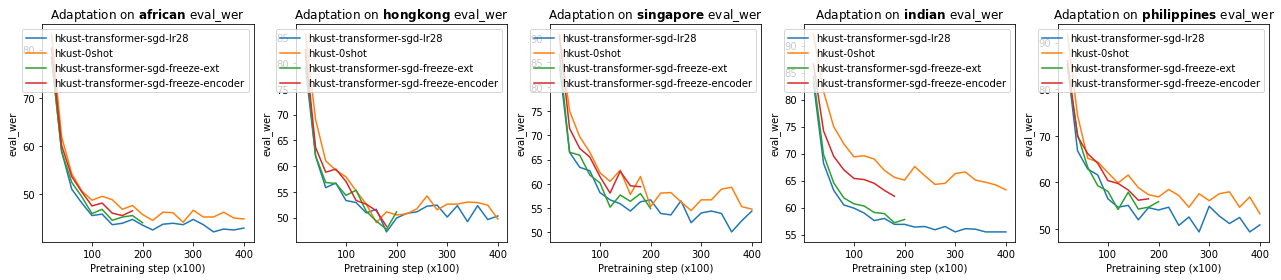

In [37]:
plot_learning_curve('eval_wer', {'setting':['hkust-transformer-sgd-lr28','hkust-transformer-sgd-freeze-ext','hkust-transformer-sgd-freeze-encoder','hkust-transformer-sgd-freeze-decoder','hkust-0shot'], 'pretrain_suffix':'cross-test-hkust'},['african','hongkong','singapore','indian','philippines'],'setting')

**sgd with fine-tuned lr achieves the best**

If we use adam, adamw, the best model is the unfine-tuned one...lol